In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

In [14]:
from sklearn.model_selection import train_test_split

# Defining Dataseat

In [15]:
from datasets import load_dataset

In [16]:
from datasets import disable_caching
disable_caching()

In [17]:
# good_files = []
# for i in range(1, 6):
#     new_files = [f"0{i}/{fname.replace('npy', '')}mp3" for fname in os.listdir(f"../../subset_moodtheme/0{i}")]
#     good_files.extend(new_files)

# test_files = [f"00/{fname.replace('npy', '')}mp3" for fname in os.listdir("../../subset_moodtheme/00")]
# print(good_files)
# print(test_files)

In [18]:
with open("goodfiles.txt", 'r') as f:
    all_files = f.readlines()
all_files = [g.strip().replace("npy", 'mp3') for g in all_files if len(g.strip()) > 0]

In [19]:
all_files[:3]

['01/846501.mp3', '34/1288334.mp3', '98/1082098.mp3']

In [20]:
good_files, test_files = train_test_split(all_files, test_size=0.2)

In [21]:
len(good_files), len(test_files)

(2200, 551)

In [22]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [23]:
good_files[0]

'48/1352848.mp3'

In [24]:
195 * 12000 / 256

9140.625

In [25]:
10337 / 195

53.01025641025641

In [26]:
train_labels = files_to_labels(good_files)

In [27]:
test_labels = files_to_labels(test_files)

In [28]:
train_labels[:2]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]

In [29]:
# train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
# test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]
train_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in good_files]
test_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in test_files]

In [30]:
train_np_files[:2], test_np_files[:2]

(['../../mtg-jamendo-dataset/all_data/48/1352848.npy',
  '../../mtg-jamendo-dataset/all_data/26/1093426.npy'],
 ['../../mtg-jamendo-dataset/all_data/66/959966.npy',
  '../../mtg-jamendo-dataset/all_data/97/1167297.npy'])

In [31]:
import time

In [32]:
# SEQ_LEN = 10000
SEQ_LEN = 3000
# SEQ_LEN = 5000

# Dataset

In [33]:
from torchvision import transforms

In [34]:
class MusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True, rolling=False, upsample_factor=10):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
        self.upsample_factor = upsample_factor
        self.rolling = rolling
        
    def __len__(self):
        return len(self.files) * self.upsample_factor

    def __getitem__(self, index):
        if index > len(self.files) * self.upsample_factor:
            self.files[index]
        effective_index = index % len(self.files)
        fname = self.files[effective_index]
        x = np.load(fname)
        x = torch.from_numpy(x).float()
        rolls = []
        if self.rolling:
            cur_start = 0
            while cur_start < x.shape[1]:
                old_x = x[:,cur_start:cur_start + self.seq_len].unsqueeze(0)
                # clamp between bounds and scale
                compressed_x = (torch.clamp(old_x, min=-90, max=30) + 90) / 120

                new_x = self.transforms(compressed_x)
                cur_start += self.seq_len
                rolls.append(new_x)
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than seqlen, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]    
        else:
            x = x[:,:self.seq_len]

        old_x = x.unsqueeze(0)
        compressed_x = (torch.clamp(old_x, min=-90, max=30) + 90) / 120
        x = self.transforms(compressed_x)
        
#         item = {"input": x, "label_ids":[effective_index], "labels": torch.tensor(self.labels[effective_index]), "pixel_values":x}
        item = {"input": x, "rolls":rolls, "label_ids":[effective_index], "labels": torch.tensor(self.labels[effective_index]), "pixel_values":x}
#         item = {"input": x, "pixel_values":x}
        
        return item

In [35]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [36]:
# img_size = 224
img_size = 496
noise_composed = transforms.Compose([
#    transforms.Resize((img_size, img_size)),
       transforms.Resize((96, img_size)),
#     transforms.Normalize((0.5542), (0.1604)),
#     AddGaussianNoise(0., 0.04)
])
nonoise_composed = transforms.Compose([
#    transforms.Resize((img_size, img_size)),
       transforms.Resize((96, img_size)),
#     transforms.Normalize((0.5542), (0.1604))
])

In [37]:
# ft_train_dataset = MusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=2)
# ft_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

ft_train_dataset = MusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=2)
ft_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

In [38]:
ft_random_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=1)

In [39]:
ft_roll_test_dataset = MusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, rolling=True, random_start=False, upsample_factor=1)
ft_roll_train_dataset = MusicDataset(train_np_files, train_labels, nonoise_composed, seq_len=SEQ_LEN, rolling=True, random_start=False, upsample_factor=1)

In [40]:
batch_size = 8

In [41]:
# train_dl = DataLoader(
#     pt_train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=0,
#     collate_fn=None,
#     pin_memory=False,
#  )

# test_dl = DataLoader(
#     pt_test_dataset,
#     batch_size=1,
#     shuffle=False,
#     num_workers=0,
#     collate_fn=None,
#     pin_memory=False,
#  )

## VIT SMALL

In [42]:
from vit_pytorch.vit_for_small_dataset import ViT

In [43]:
from tqdm import tqdm
import torch.optim as optim

In [44]:
class MultiHeadedOutput(nn.Module):
    def __init__(self):
        super(MultiHeadedOutput, self).__init__()
        
        self.heads = nn.ModuleList([
            nn.Sequential(
                    nn.LayerNorm(512),
                    nn.Linear(512, 1024),
                    nn.LeakyReLU(), 
                    nn.Dropout(0.1),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(), 
                    nn.Linear(512, 1)
#                     nn.Linear(512, 2)
            ) for i in range(15)
#             ) for i in range(1)
        ])
        
    def forward(self, x: torch.Tensor):
        outputs = torch.stack([h(x) for h in self.heads], dim=1)
        return outputs

# Finetuning MAE for Task

In [45]:
h = MultiHeadedOutput()

In [46]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [47]:
# batch_size = 32
# batch_size = 64
batch_size = 128

In [48]:
ft_train_dl = DataLoader(
    ft_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

ft_test_dl = DataLoader(
    ft_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )


ft_random_test_dl = DataLoader(
    ft_random_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )


In [49]:
from transformers import ViTConfig, ViTModel
# from vit_pytorch import ViT, MAE
from vit_pytorch.vit_for_small_dataset import ViT

In [50]:
v_for_downstream = ViT(
    image_size = (96, 496),
    patch_size = 16,
    num_classes = 15,
    dim = 512,
#     depth = 6,
#     heads = 16,
    depth = 4,
    heads = 6,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1
)

In [51]:
v_for_downstream.mlp_head

Sequential(
  (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=512, out_features=15, bias=True)
)

In [52]:
def set_module_requires_grad_(module, requires_grad):
    for param in module.parameters():
        param.requires_grad = requires_grad
def freeze_all_layers_(module):
    set_module_requires_grad_(module, False)

In [53]:
new_head = MultiHeadedOutput()

In [54]:
v_for_downstream.mlp_head = new_head

In [55]:
model = v_for_downstream

In [56]:
model = model.to(device)

In [57]:
from tqdm import tqdm
import torch.optim as optim

In [58]:
pos_weight = 1 / (torch.sum(torch.tensor(test_labels), dim=0) / len(test_labels))
pos_weight = 0 * torch.tensor(pos_weight) + 1
# pos_weight = pos_weight / 2

C:\Users\aag12\AppData\Local\Temp\ipykernel_38852\2238443094.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  pos_weight = 1 / (torch.sum(torch.tensor(test_labels), dim=0) / len(test_labels))
C:\Users\aag12\AppData\Local\Temp\ipykernel_38852\2238443094.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = 0 * torch.tensor(pos_weight) + 1


In [59]:
pos_weight

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       dtype=torch.float64)

In [60]:
# optimizer = optim.AdamW(model.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.parameters(), lr=1e-4)
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-3)
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-2)
optimizer = optim.AdamW(model.mlp_head.parameters(), lr=3e-5, weight_decay=0.05, betas=(0.9, 0.95))
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=1e-3, weight_decay=0.1, betas=(0.9, 0.95))
# optimizer = optim.AdamW(model.mlp_head.parameters(), lr=5e-3, weight_decay=0.1, betas=(0.9, 0.95))
# criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight.to(device))
# criterions = [nn.BCEWithLogitsLoss(pos_weight=pos_weight[i].unsqueeze(0).to(device)) for i in range(15)]
criterions = [nn.BCEWithLogitsLoss() for i in range(15)]

In [61]:
def get_mask(targs):
    mask = []
    for val in targs:
        m = int(val) == 1 or random.random() < (1/15)
        mask.append(m)
    return mask

In [62]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)

#         total_loss += criterion(outputs, labels.float())
        for i in range(15):
            criterion = criterions[i]
#             target = torch.zeros_like(outputs[:,i])
#             target = outputs[:,i,1]
#             target[:,labels[:,i].long()] = 1
#             for ind in range(len(target)):
#                 target[ind,labels[ind,i].long()] = 1
#             target = target.to(device)
#             total_loss += criterion(outputs[:,i], target)
#             total_loss += criterion(outputs[:,i], labels[:,i])
            total_loss += criterion(outputs[:,i,0], labels[:,i])
    return total_loss.item()

In [64]:
model.train()
ft_train_losses = []
ft_test_losses = []
for epoch in range(10):
# for epoch in range(5):
    total_loss = 0
#     for batch in train_loader:
    for batch_idx, data in tqdm(enumerate(ft_train_dl), total=len(ft_train_dl)):
        these_losses = []
        optimizer.zero_grad()
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        
#         loss = criterion(outputs, labels)
        loss = 0
        for i in range(15):
            criterion = criterions[i]
#             target = torch.zeros_like(outputs[:,i])
#             target = outputs[:,i, 1]
#             target[:,labels[:,i].long()] = 1
#             for ind in range(len(target)):
#                 target[ind,labels[ind,i].long()] = 1
#             target = target.to(device)
#             loss += criterion(outputs[:,i,1], target)
            
            cur_outs = outputs[:,i,0]
            cur_targs = labels[:,i]
            
            num_pos = int(cur_targs.sum()) - 2
            num_neg_to_include = max(num_pos, 1)
            pos_outs = cur_outs[cur_targs == 1]
            neg_outs = cur_outs[cur_targs == 0]
            
            pos_targs = cur_targs[cur_targs == 1]
            neg_targs = cur_targs[cur_targs == 0]
            
            balanced_outs = torch.cat([pos_outs, neg_outs[:num_neg_to_include]])
            balanced_targs = torch.cat([pos_targs, neg_targs[:num_neg_to_include]])
            
            loss += criterion(cur_outs, cur_targs)
        loss.backward()
        optimizer.step()
        # for bookkeeping
        total_loss += loss.item()
        
    with torch.no_grad():
        train_total_loss = total_loss
        test_loss = get_total_loss(model, ft_test_dl)
        ft_train_losses.append(train_total_loss)
        ft_test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Total Loss: {train_total_loss}; Test Loss: {test_loss}")
#         print(f"Epoch: {epoch}; Loss: {adjusted}; Test Loss: {test_loss}")

_ = model.eval()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:48<00:00,  1.38s/it]


Epoch: 0; Total Loss: 205.49754866518683; Test Loss: 2078.778688196093


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:39<00:00,  1.13s/it]


Epoch: 1; Total Loss: 133.20868206121182; Test Loss: 2078.5395095981658


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:41<00:00,  1.18s/it]


Epoch: 2; Total Loss: 132.53571232668278; Test Loss: 2072.513253238052


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:38<00:00,  1.11s/it]


Epoch: 3; Total Loss: 132.74238805120208; Test Loss: 2080.8327669762075


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:40<00:00,  1.15s/it]


Epoch: 4; Total Loss: 132.65179702865134; Test Loss: 2077.8955909200013


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:42<00:00,  1.21s/it]


Epoch: 5; Total Loss: 132.6398768435174; Test Loss: 2083.387766016647


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:40<00:00,  1.16s/it]


Epoch: 6; Total Loss: 132.6242459466254; Test Loss: 2078.5912033319473


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:41<00:00,  1.17s/it]


Epoch: 7; Total Loss: 132.58005256777201; Test Loss: 2077.745145946741


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:41<00:00,  1.18s/it]


Epoch: 8; Total Loss: 132.63490434916457; Test Loss: 2076.3672503083944


100%|██████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:40<00:00,  1.16s/it]


Epoch: 9; Total Loss: 132.7075645996762; Test Loss: 2075.591903489083


Text(0.5, 1.0, 'MAE v2 (no norm): Finetuning Train/Test Loss')

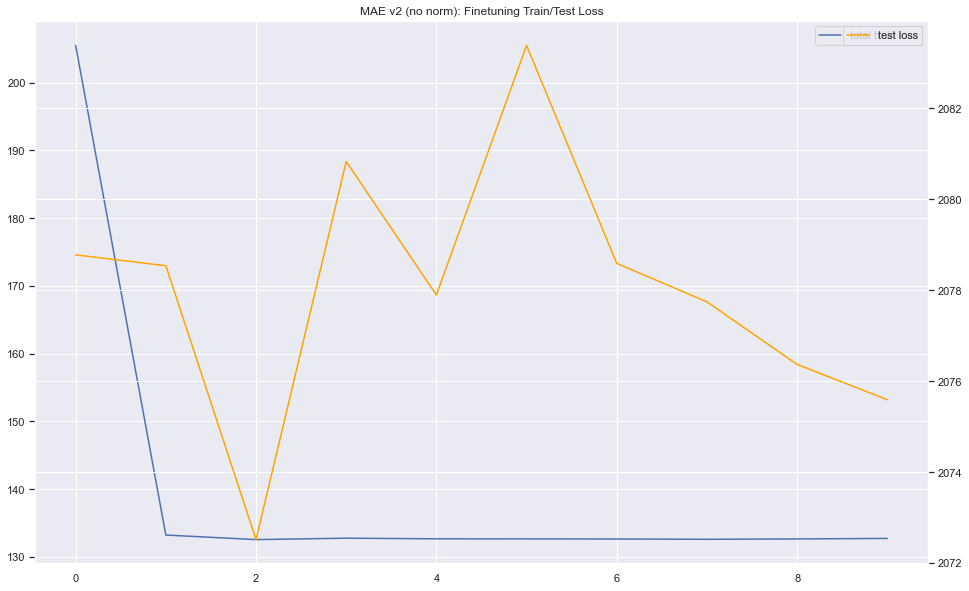

In [65]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(ft_train_losses)))
sns.lineplot(x=ranger, y=ft_train_losses, label="total train loss", alpha=1)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
ax2 = plt.twinx()
sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", ax=ax2, color="orange", alpha=1)
# sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", color="orange", alpha=0.5)
# plt.title("MAE v1: Finetuning Train/Test Loss")
plt.title("MAE v2 (no norm): Finetuning Train/Test Loss")
# plt.savefig("mae_v1.png")

In [69]:
model.eval()

combined_preds = []
combined_labels = []

with torch.no_grad():
#     a = model(dataset[2]['input'].to(device))
    total_correct = 0
    zero_correct = 0
    total_values = 0
    only_positives = [0, 0]
    for batch_idx, data in enumerate(ft_test_dl):
#     for batch_idx, data in enumerate(ft_random_test_dl):
#     for batch_idx, data in enumerate(ft_roll_test_dataset):
#     for batch_idx, data in enumerate(ft_roll_train_dataset):
#     for batch_idx, data in enumerate(ft_train_dl):
        if 'rolls' not in data or len(data['rolls']) == 0:
            inputs, labels = data['input'].to(device), data['labels'].to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs[:,:,0])
        else:
            all_outputs = []
            labels = data['labels'].to(device)
            labels = labels.unsqueeze(0)
            for inputs in data['rolls']:
                cur_inputs = inputs.unsqueeze(0).to(device)
                outputs = model(cur_inputs)
                outputs = torch.sigmoid(outputs[:,:,0])
                all_outputs.append(outputs)
            outputs = torch.cat(all_outputs).mean(dim=0)
            outputs = outputs.unsqueeze(0)
#         combined_preds.append(outputs)
        combined_labels.append(labels)
        
        outlabels = torch.zeros_like(outputs)
#         outlabels = torch.argmax(outputs, dim=-1)
#         outlabels = torch.outputs
        combined_preds.append(outputs)
        outlabels[outputs >= 0.5] = 1
        outlabels[outputs < 0.5] = 0
        
        num_correct = torch.sum(outlabels == labels).item()
        
        num = len(labels) * 15
        
        total_correct += num_correct
        total_values += num
        zero_correct += torch.sum(labels == 0).item()
        
        only_positives[0] += torch.sum(labels).item()
        only_positives[1] += torch.sum(labels[labels == 1] == outlabels[labels == 1]).item()
        

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("Performance on positive labels")

print(only_positives[1] / only_positives[0])

print(f"{only_positives[1]} out of {only_positives[0]}")

print("WHAT IF WE JUST PREDICTED ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

0.9304295220810648
7690 out of 8265
Performance on positive labels
0.0
0 out of 575.0
WHAT IF WE JUST PREDICTED ZERO
0.9304295220810648
7690 out of 8265


In [70]:
all_preds = torch.cat(combined_preds)
all_labels = torch.cat(combined_labels)
all_preds.shape, all_labels.shape

(torch.Size([551, 15]), torch.Size([551, 15]))

In [71]:
len(ft_test_dataset)

551

In [72]:
from sklearn import metrics

In [73]:
torch.cat(combined_labels).sum(dim=0) / len(combined_labels) * 100

tensor([ 3.0853,  3.6298,  6.8966,  6.1706,  6.8966,  6.5336,  6.8966,  6.5336,
         5.9891,  8.3485,  8.1670,  7.2595,  8.8929,  8.3485, 10.7078],
       device='cuda:0', dtype=torch.float64)

In [74]:
aucs = []
for i in range(15):
    preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print(f"Head: {i}; AUC: {auc}")

Head: 0; AUC: 0.544393038114122
Head: 1; AUC: 0.47900188323917137
Head: 2; AUC: 0.5563250230840259
Head: 3; AUC: 0.5054613721697576
Head: 4; AUC: 0.49764029957935774
Head: 5; AUC: 0.4665318230852211
Head: 6; AUC: 0.43698060941828254
Head: 7; AUC: 0.523705501618123
Head: 8; AUC: 0.49432549432549433
Head: 9; AUC: 0.55469220835127
Head: 10; AUC: 0.5203776899429073
Head: 11; AUC: 0.4900195694716243
Head: 12; AUC: 0.5385397186763152
Head: 13; AUC: 0.5179724494188549
Head: 14; AUC: 0.45993523494556976


In [75]:
good_aucs = [a for a in aucs if a > 0.5]

In [76]:
sum(good_aucs) / len(good_aucs)

0.532683375171922

In [77]:
sum(aucs) / (len(aucs))

0.5057267943626731

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(targs, preds)

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [ ]:
from vit_pytorch.learnable_memory_vit import ViT, Adapter

In [ ]:
plt.figure(figsize=(16, 10))
preds = all_preds[:,3].cpu()
targs = all_labels[:,3].cpu()
fpr, tpr, _ = metrics.roc_curve(targs, preds)
auc = metrics.roc_auc_score(targs, preds)
plt.plot(fpr,tpr,label="MAE v1 model, feature 3, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(targs, np.zeros_like(targs))
auc = metrics.roc_auc_score(targs, np.zeros_like(targs))
plt.plot(fpr,tpr,label="y=x, auc="+str(auc))

plt.legend(loc=4)
plt.show()

# SMALL HFACE TESTING

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from transformers import ViTForImageClassification, ViTMAEForPreTraining, ViTMAEConfig, ViTFeatureExtractor

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers.trainer_utils import get_last_checkpoint

In [ ]:
configuration = ViTMAEConfig(
                    image_size=224, 
                    num_channels=1, 
#                     norm_pix_loss=True, 
                    num_attention_heads=6, 
                    num_hidden_layers=3,
                    decoder_intermediate_size=1024,
                    intermediate_size=2048,
                    num_labels=15
)

In [ ]:
v = ViTMAEForPreTraining.from_pretrained("hface_test_v0/final_mae.pt/")

In [ ]:
vit_for_class = ViTForImageClassification(configuration)

In [ ]:
vit_for_class.vit.load_state_dict(v.vit.state_dict())

In [ ]:
model = vit_for_class

In [ ]:
class MultiHeadedOutput(nn.Module):
    def __init__(self):
        super(MultiHeadedOutput, self).__init__()
        
        self.heads = nn.ModuleList([
            nn.Sequential(
                    nn.Linear(768, 512),
                    nn.LeakyReLU(), 
                    nn.Linear(512, 1)
            ) for i in range(15)
#             ) for i in range(1)
        ])
        
    def forward(self, x: torch.Tensor):
        outputs = torch.concat([h(x) for h in self.heads], dim=1)
        return outputs

In [ ]:
model.classifier = MultiHeadedOutput().to(device)

In [ ]:
# for p in model.classifier.parameters():
#     print(p)
#     print(p.requires_grad)

In [ ]:
_ = model.to(device)

In [ ]:
test_inp = ft_test_dataset[0]['input']

test_inp = torch.stack([test_inp, test_inp, test_inp]).to(device)

In [ ]:
test_inp.shape, test_inp.device

In [ ]:
model.device

In [ ]:
# model

In [ ]:
model(test_inp)

In [ ]:
! rm -rf hface_classtest_v0/

In [ ]:
import torch.optim as optim

In [ ]:
training_args = TrainingArguments(
    "hface_classtest_v0",
#     learning_rate=1.5e-4,
    learning_rate=5e-4,
    weight_decay=0.05,
#     num_train_epochs=10,
    num_train_epochs=5,
#     per_device_train_batch_size=8,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=1,
    logging_steps=10,
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=3,
    label_names=["labels"],
    disable_tqdm=True,
    report_to="none",
)

In [ ]:
pos_weight = 1 / (torch.sum(torch.tensor(test_labels), dim=0) / len(test_labels))
# pos_weight = pos_weight / 2

In [ ]:
pos_weight

In [ ]:
torch.clamp(torch.tensor(0.001), torch.tensor(0.05), torch.tensor(0.95))

In [ ]:
pos_weight / 0.8

In [ ]:
class WeightedTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rolling_mean_matrix = None
        self.max_factor = torch.tensor(1.5).to(device)
        self.min_factor = torch.tensor(0.8).to(device)
        
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(inputs.get("pixel_values"))
        logits = outputs.get('logits')
        preds = torch.sigmoid(torch.tensor(logits))
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = 0
        mean = preds.mean(dim=0)
        if self.rolling_mean_matrix is None:
            self.rolling_mean_matrix = []
        
        this_batch_weight = pos_weight.to(device)
        
        self.rolling_mean_matrix.append(mean)
        cur_means = torch.stack(self.rolling_mean_matrix).mean(dim=0)
        for i in range(cur_means.shape[0]):
            if cur_means[i] > 0:
                factor = torch.clamp((cur_means[i] / 0.5), self.min_factor, self.max_factor)
#                 this_batch_weight[i] = this_batch_weight[i] / factor
                this_batch_weight[i] = factor
        
        if len(self.rolling_mean_matrix) > 5:
            self.rolling_mean_matrix = self.rolling_mean_matrix[1:]
        
        
        loss_fct = nn.BCEWithLogitsLoss(pos_weight = this_batch_weight, reduction="sum")
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
model

In [ ]:
for p in model.vit.parameters():
    p.requires_grad = False

In [ ]:
import transformers

In [ ]:
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=0.05, betas=(0.9, 0.95))

In [ ]:
lr = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=5 * len(ft_train_dataset))

In [ ]:
trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=ft_train_dataset,
        eval_dataset=ft_test_dataset,
        optimizers=[optimizer, lr]
    )

In [ ]:
# trainer.evaluate()
# # trainer.predict(ft_train_dataset)

In [ ]:
trainer.evaluate()

In [ ]:
# preds = trainer.predict(ft_test_dataset)

In [ ]:
trainer.train()

In [ ]:
# trainer.evaluate(ft_train_dataset)

In [ ]:
# trainer.evaluate(ft_test_dataset)

In [ ]:
test_preds = trainer.predict(ft_test_dataset)

In [ ]:
test_preds.metrics

In [ ]:
labels = torch.stack([ft_test_dataset[i]['labels'] for i in range(len(ft_test_dataset))])

In [ ]:
labels.shape

In [ ]:
labels.sum(dim=0)

In [ ]:
preds = torch.sigmoid(torch.tensor(test_preds.predictions))

preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

In [ ]:
num_correct = torch.sum(preds == labels).item()
num = len(labels) * 15
zero_correct = torch.sum(labels == 0).item()

In [ ]:
num_correct / num

In [ ]:
preds = torch.sigmoid(torch.tensor(test_preds.predictions))

In [ ]:
preds

In [ ]:
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0

In [ ]:
preds

In [ ]:
torch.sum(labels[labels == 1] == preds[labels == 1]).item() / torch.sum(labels).item()

In [ ]:
all_preds = preds
all_labels = labels

In [ ]:
from sklearn import metrics

In [ ]:
all_preds.mean(dim=0)

In [ ]:
aucs = []
for i in range(15):
    cur_preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, cur_preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print(f"Head: {i}; AUC: {auc}")

In [ ]:
sum(aucs) / len(aucs)